In [1]:
import matplotlib.pyplot as plt

import sim.evaluation
import sim.model_configuration
import sim.petrinet_replay
import sim.simulator
import sim.viz
from fitting_machinery import fit_to_log
import queues.util as util
from queues.lifecycles import LifecycleAutomaton, lifecycle_census
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]

%load_ext autoreload
%aimport sim.petrinet_replay
%aimport sim.viz
%aimport sim.replay_tracking
%aimport sim.simulator
%aimport sim.sim_model
%aimport sim.sim_data
%aimport sim.managers
%aimport sim.parameter_extraction
%aimport sim.petrinet_replay
%aimport sim.parameter_defaults
%aimport sim.model_configuration
%aimport sim.time_utils
%aimport sim.utils
%aimport sim.evaluation
%aimport sim.case
%aimport sim.fitting_machinery
%aimport queues.lifecycles

%autoreload 1

%config InlineBackend.figure_format = 'retina'

ModuleNotFoundError: No module named 'sim.evaluation'

In [ ]:
log, petrinet_model = sim.importing.load_input('eval/reallife/RequestForPayment.xes.gz', 'eval/reallife/request_for_payment_simplified_net.apnml')
sim.viz.save_petrinet(petrinet_model)

In [3]:
orig_log[0]

{'attributes': {'concept:name': 'default_process0'}, 'events': [{'concept:name': 'A', 'time:timestamp': datetime.datetime(2020, 11, 9, 9, 0, tzinfo=datetime.timezone.utc), 'org:resource': 'n/a', 'lifecycle:transition': 'schedule'}, '..', {'concept:name': 'E', 'time:timestamp': datetime.datetime(2020, 11, 9, 10, 25, tzinfo=datetime.timezone.utc), 'org:resource': 'System', 'lifecycle:transition': 'complete'}]}

In [4]:
orig_log[0][0]

{'concept:name': 'A', 'time:timestamp': datetime.datetime(2020, 11, 9, 9, 0, tzinfo=datetime.timezone.utc), 'org:resource': 'n/a', 'lifecycle:transition': 'schedule'}

In [5]:
dlog = util.general_log_filter(orig_log, lambda ev: ev['lifecycle:transition'] in {'complete'})
flog = util.general_log_filter(orig_log, lambda ev: ev['lifecycle:transition'] in {'start', 'complete'})

In [6]:
from pm4py.discovery import discover_petri_net_inductive
net, im, fm = discover_petri_net_inductive(dlog)

In [7]:
# from pm4py.objects.petri.importer import importer as petri_importer
# net, im, fm = petri_importer.apply('../logs/reallife/bpi/bpi17cut.apnml')

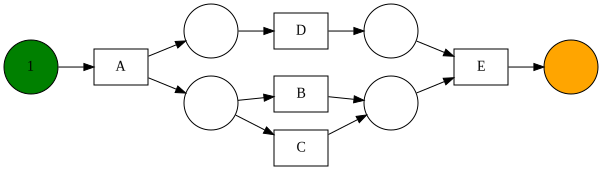

In [8]:
from pm4py.visualization.petrinet import visualizer as petri_visualizer
petri_visualizer.apply(net, im, fm)

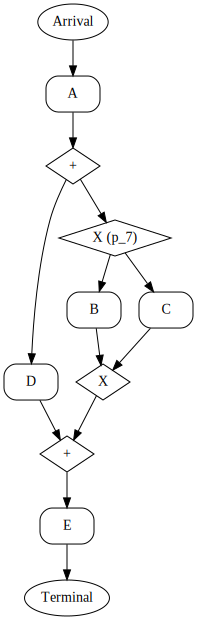

In [9]:
graph = sim.model_configuration.create_sim_graph(net, im, fm)
sim.viz.visualize_sim_graph(graph, label_decision_points=True)

In [10]:
def trackers_overview(trackers):
    def q_plot(key):
        for a, tr in trackers['activity_trackers'].items():
            tr.queue_model.queueing_history_df[key].plot(label=f'{a}')
        plt.legend()
        plt.title(f'chronological {key}')
        plt.show()
    q_plot('queue_length')
    print('act\tavg wait\tavg processing')
    for a, tr in trackers['activity_trackers'].items():
        print(f'{a}\t{tr.queue_model.queueing_history_df["wait"].mean()}\t{tr.processing_model.processing_history_df["duration"].mean()}')

def log_to_sim(input_log, viz_graph=False):
    flog = util.general_log_filter(input_log, lambda ev: ev['lifecycle:transition'] in  {'start','complete'})
    trackers, decision_points = sim.petrinet_replay.replay_log(flog, net, im, fm)
    graph = sim.model_configuration.create_sim_graph(net, im, fm, decision_points)
    config = sim.model_configuration.create_model_configuration(**trackers)
    sm = sim.simulator.create_simulation_model(graph, config, sim.simulator.default_execution_parameters())
    simul = sim.simulator.simulate(sm)
    sim_log = simul.get_log()
    trackers_overview(trackers)
    return sim_log

In [11]:
lifecycle_census(flog)

A
	count		valid	lifecycle sequence
	1000(100.00%)	True	('start', 'complete')
	total valid lifecycles: 1000/1000(100.00%)
B
	count		valid	lifecycle sequence
	506(100.00%)	True	('start', 'complete')
	total valid lifecycles: 506/506(100.00%)
D
	count		valid	lifecycle sequence
	1000(100.00%)	True	('start', 'complete')
	total valid lifecycles: 1000/1000(100.00%)
E
	count		valid	lifecycle sequence
	1000(100.00%)	True	('start', 'complete')
	total valid lifecycles: 1000/1000(100.00%)
C
	count		valid	lifecycle sequence
	494(100.00%)	True	('start', 'complete')
	total valid lifecycles: 494/494(100.00%)


selecting modeling assumptions:
FractionalDelay(defaultdict(<function FractionalDelay.__init__.<locals>.<lambda> at 0x000001F71B197EE0>, {})) <sim.replay_tracking.FractionalDelayAndProcessing object at 0x000001F71B93D7C0>
selecting model config:
Arrival(process_start=2020-11-09 10:00:00+01:00, inter_arrivals=EmpiricalSampler(percentiles=[numpy.timedelta64(0,'ns'), numpy.timedelta64(300000000000,'ns'), numpy.timedelta64(541000000000,'ns'), numpy.timedelta64(780000000000,'ns'), numpy.timedelta64(1032800000000,'ns'), numpy.timedelta64(1320750000000,'ns'), numpy.timedelta64(1562000000000,'ns'), numpy.timedelta64(1860000000000,'ns'), numpy.timedelta64(2157200000000,'ns'), numpy.timedelta64(2520000000000,'ns'), numpy.timedelta64(2935500000000,'ns'), numpy.timedelta64(3301150000000,'ns'), numpy.timedelta64(3839600000000,'ns'), numpy.timedelta64(4320000000000,'ns'), numpy.timedelta64(4917700000000,'ns'), numpy.timedelta64(5594000000000,'ns'), numpy.timedelta64(6419600000000,'ns'), numpy.timede

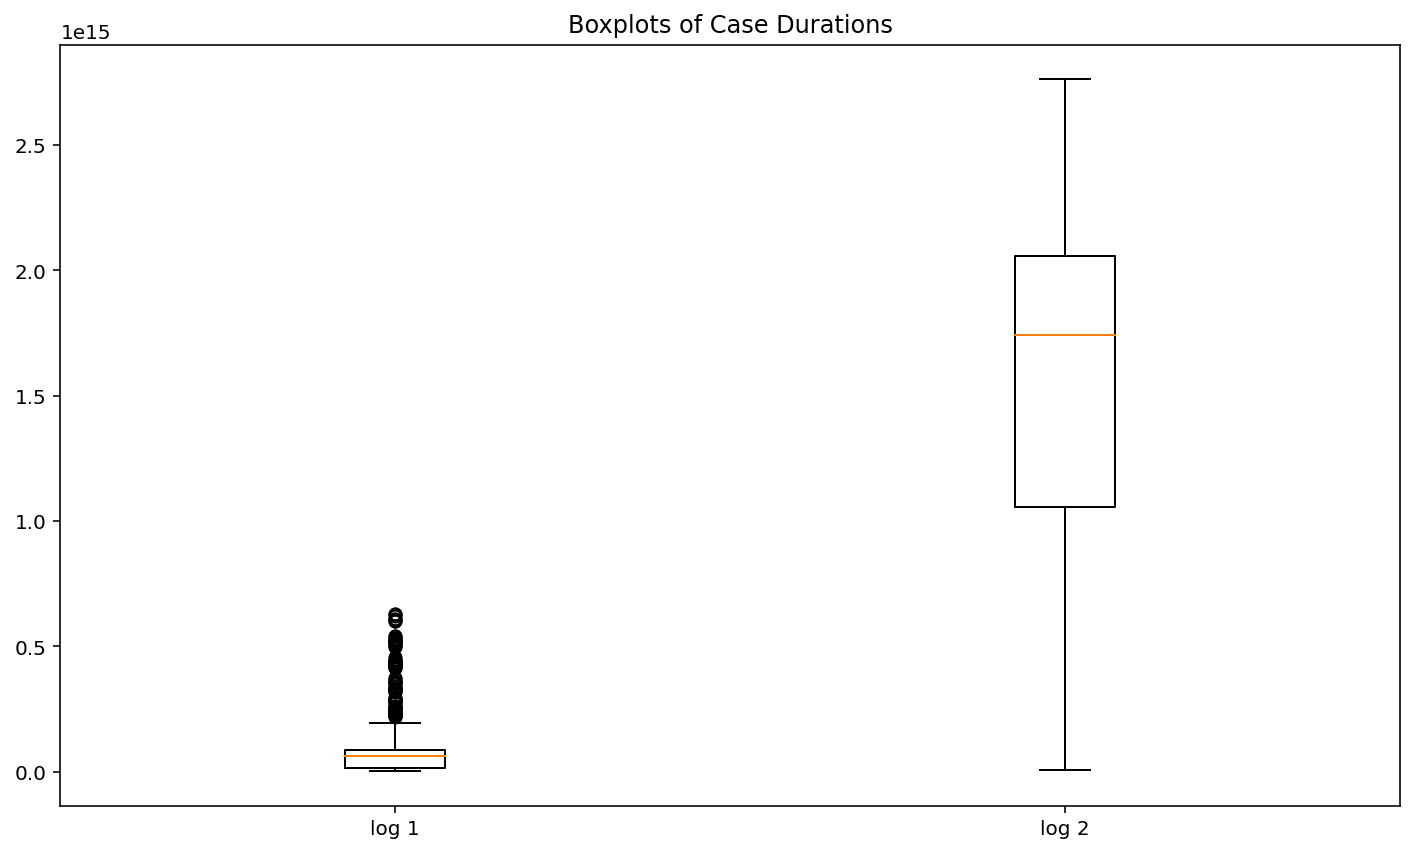

log 1
count                         1000
mean        0 days 23:29:59.636000
std      1 days 07:36:32.697345034
min                0 days 00:33:01
25%                0 days 03:57:46
50%         0 days 16:53:28.500000
75%         0 days 23:53:17.750000
max                7 days 06:44:04
dtype: object
log 2
count                          1000
mean     17 days 17:23:52.311374215
std       8 days 02:21:24.681017932
min       0 days 01:22:30.338130487
25%         12 days 05:22:49.750000
50%                20 days 03:58:35
75%         23 days 19:38:36.750000
max                31 days 23:33:57
dtype: object


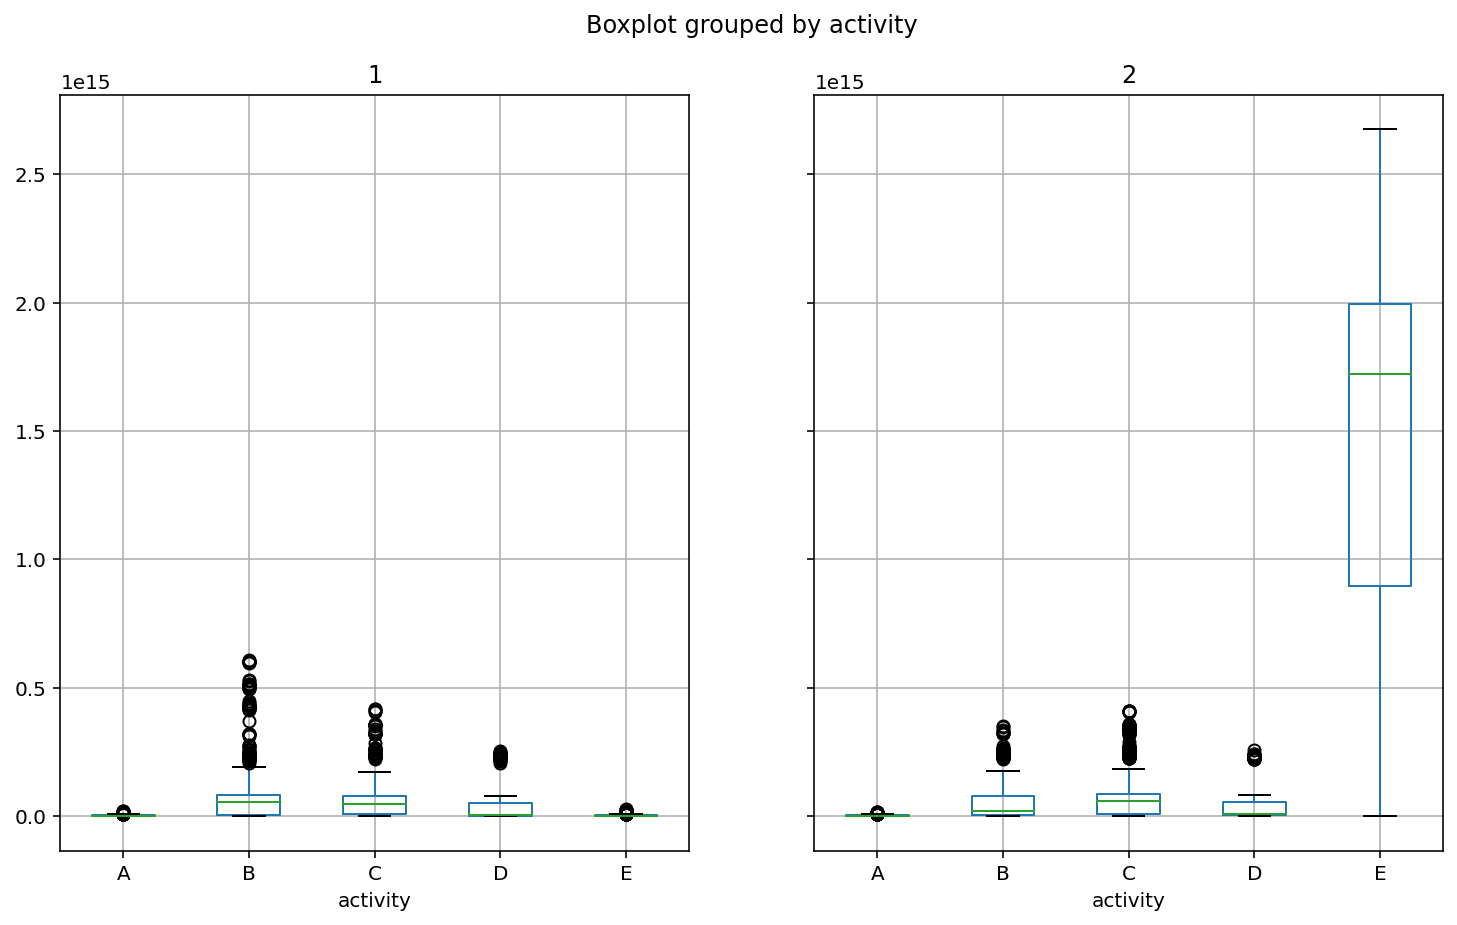

#########
#0 combination (2, 2)
(0.01537500000000001, 1728892307452931.2)
FractionalDelay(defaultdict(<function FractionalDelay.__init__.<locals>.<lambda> at 0x000001F71B1EC1F0>, {'A': 0.75, 'B': 0.75, 'D': 0.75, 'E': 0.75, 'C': 0.75})) <sim.replay_tracking.FractionalDelayAndProcessing object at 0x000001F71B93DB20>
Arrival(process_start=2020-11-09 10:00:00+01:00, inter_arrivals=EmpiricalSampler(percentiles=[numpy.timedelta64(0,'ns'), numpy.timedelta64(300000000000,'ns'), numpy.timedelta64(541000000000,'ns'), numpy.timedelta64(780000000000,'ns'), numpy.timedelta64(1032800000000,'ns'), numpy.timedelta64(1320750000000,'ns'), numpy.timedelta64(1562000000000,'ns'), numpy.timedelta64(1860000000000,'ns'), numpy.timedelta64(2157200000000,'ns'), numpy.timedelta64(2520000000000,'ns'), numpy.timedelta64(2935500000000,'ns'), numpy.timedelta64(3301150000000,'ns'), numpy.timedelta64(3839600000000,'ns'), numpy.timedelta64(4320000000000,'ns'), numpy.timedelta64(4917700000000,'ns'), numpy.timedelta64(5

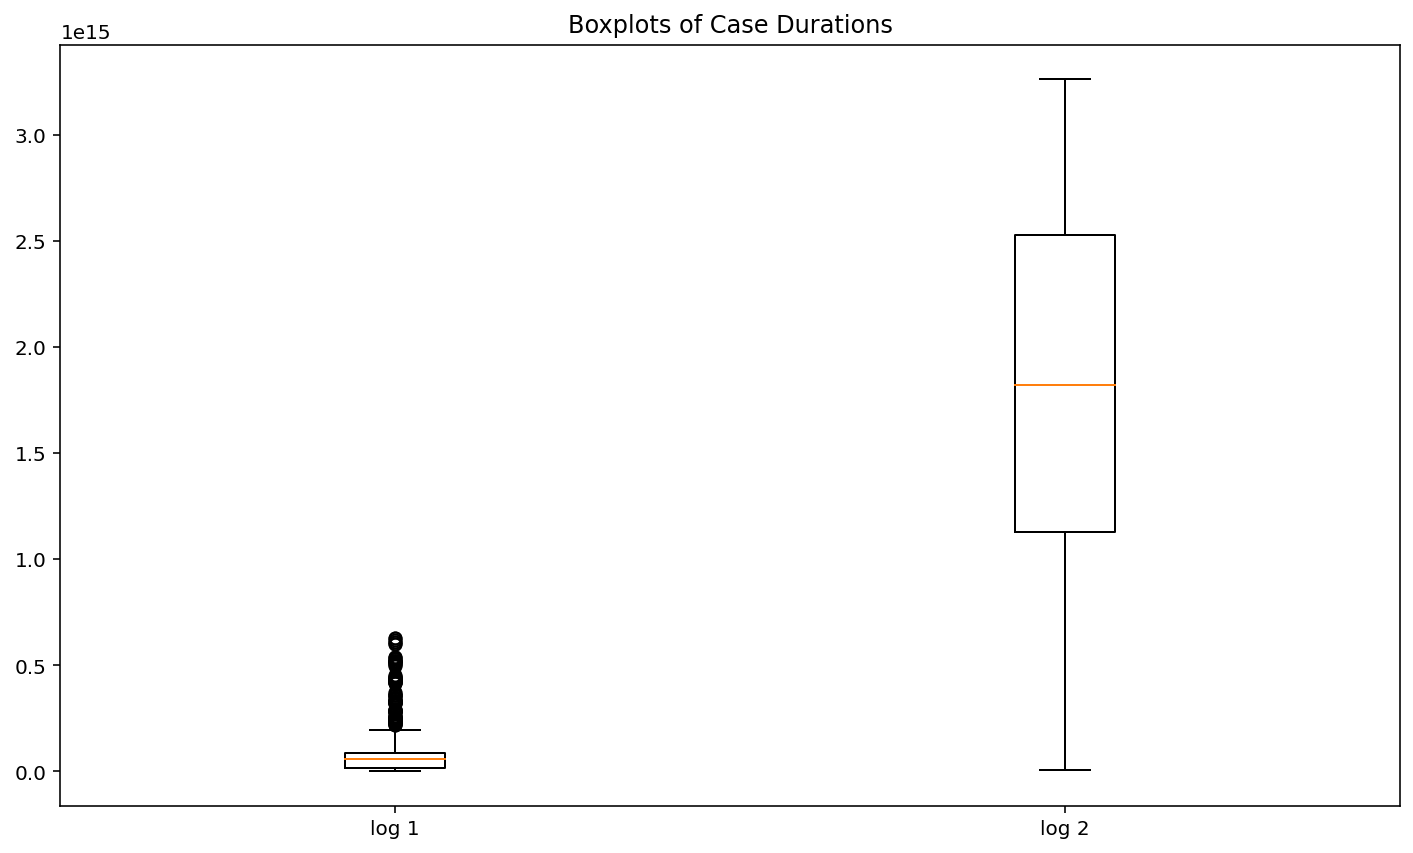

log 1
count                         1000
mean        0 days 23:29:59.636000
std      1 days 07:36:32.697345034
min                0 days 00:33:01
25%                0 days 03:57:46
50%         0 days 16:53:28.500000
75%         0 days 23:53:17.750000
max                7 days 06:44:04
dtype: object
log 2
count                          1000
mean     20 days 23:44:51.943452931
std       9 days 11:43:28.208432114
min                 0 days 02:30:09
25%         13 days 00:58:18.500000
50%                21 days 01:01:27
75%         29 days 05:58:12.250000
max                37 days 17:49:58
dtype: object


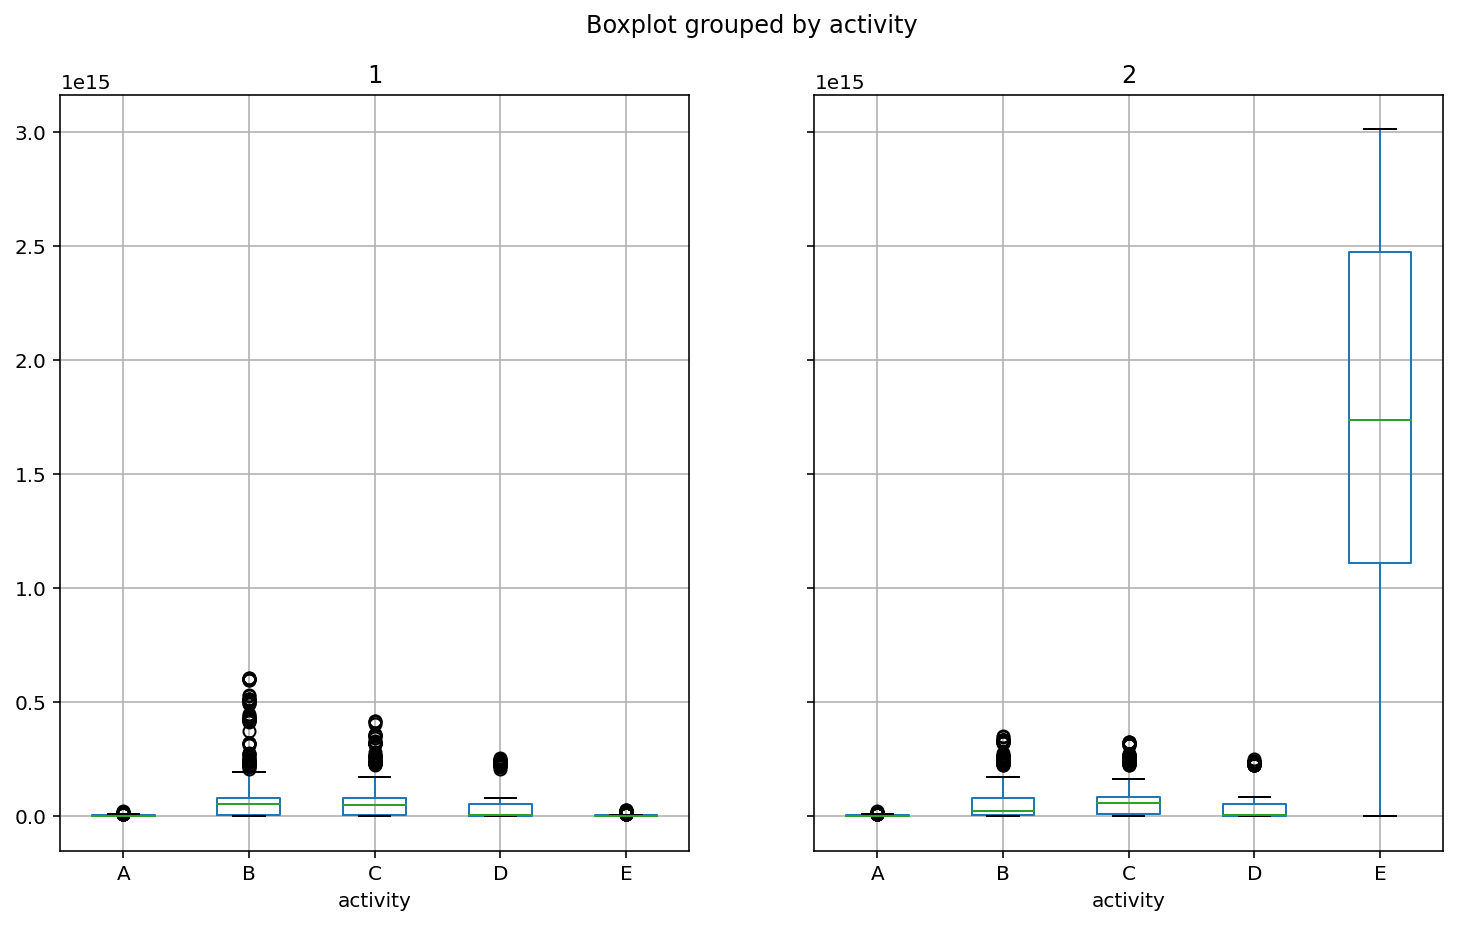

#########
#0 combination (3, 2)
(0.01550000000000001, 818110411823296.2)
FractionalDelay(defaultdict(<function FractionalDelay.__init__.<locals>.<lambda> at 0x000001F71B4A30D0>, {'A': 1, 'B': 1, 'D': 1, 'E': 1, 'C': 1})) <sim.replay_tracking.FractionalDelayAndProcessing object at 0x000001F71B93DCA0>
Arrival(process_start=2020-11-09 10:00:00+01:00, inter_arrivals=EmpiricalSampler(percentiles=[numpy.timedelta64(0,'ns'), numpy.timedelta64(300000000000,'ns'), numpy.timedelta64(541000000000,'ns'), numpy.timedelta64(780000000000,'ns'), numpy.timedelta64(1032800000000,'ns'), numpy.timedelta64(1320750000000,'ns'), numpy.timedelta64(1562000000000,'ns'), numpy.timedelta64(1860000000000,'ns'), numpy.timedelta64(2157200000000,'ns'), numpy.timedelta64(2520000000000,'ns'), numpy.timedelta64(2935500000000,'ns'), numpy.timedelta64(3301150000000,'ns'), numpy.timedelta64(3839600000000,'ns'), numpy.timedelta64(4320000000000,'ns'), numpy.timedelta64(4917700000000,'ns'), numpy.timedelta64(5594000000000,'ns

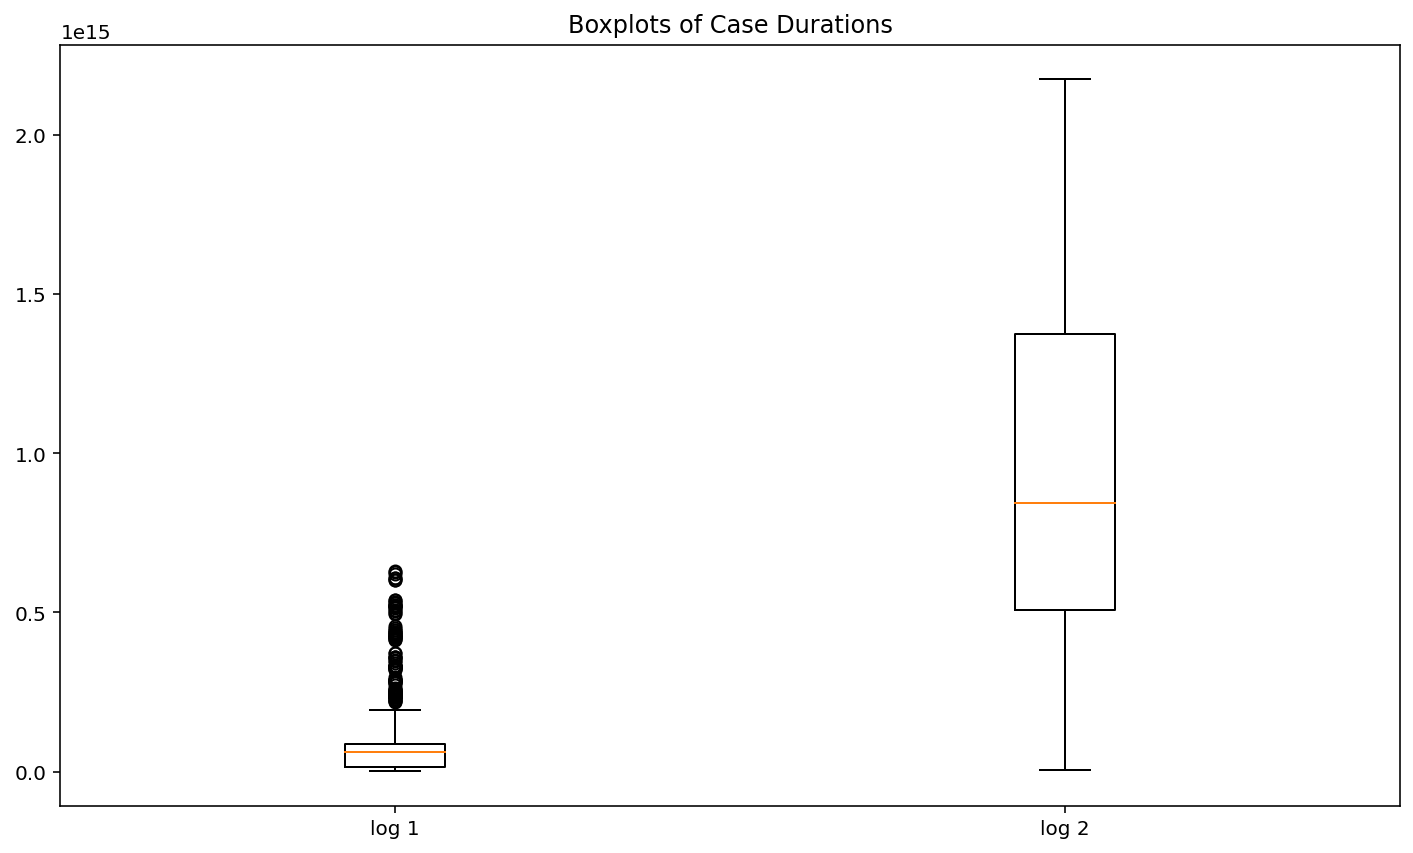

log 1
count                         1000
mean        0 days 23:29:59.636000
std      1 days 07:36:32.697345034
min                0 days 00:33:01
25%                0 days 03:57:46
50%         0 days 16:53:28.500000
75%         0 days 23:53:17.750000
max                7 days 06:44:04
dtype: object
log 2
count                          1000
mean     10 days 10:45:10.047823296
std       6 days 09:03:09.714312174
min                 0 days 01:21:00
25%          5 days 21:26:43.500000
50%                 9 days 18:29:27
75%         15 days 21:59:12.500000
max                25 days 04:13:57
dtype: object


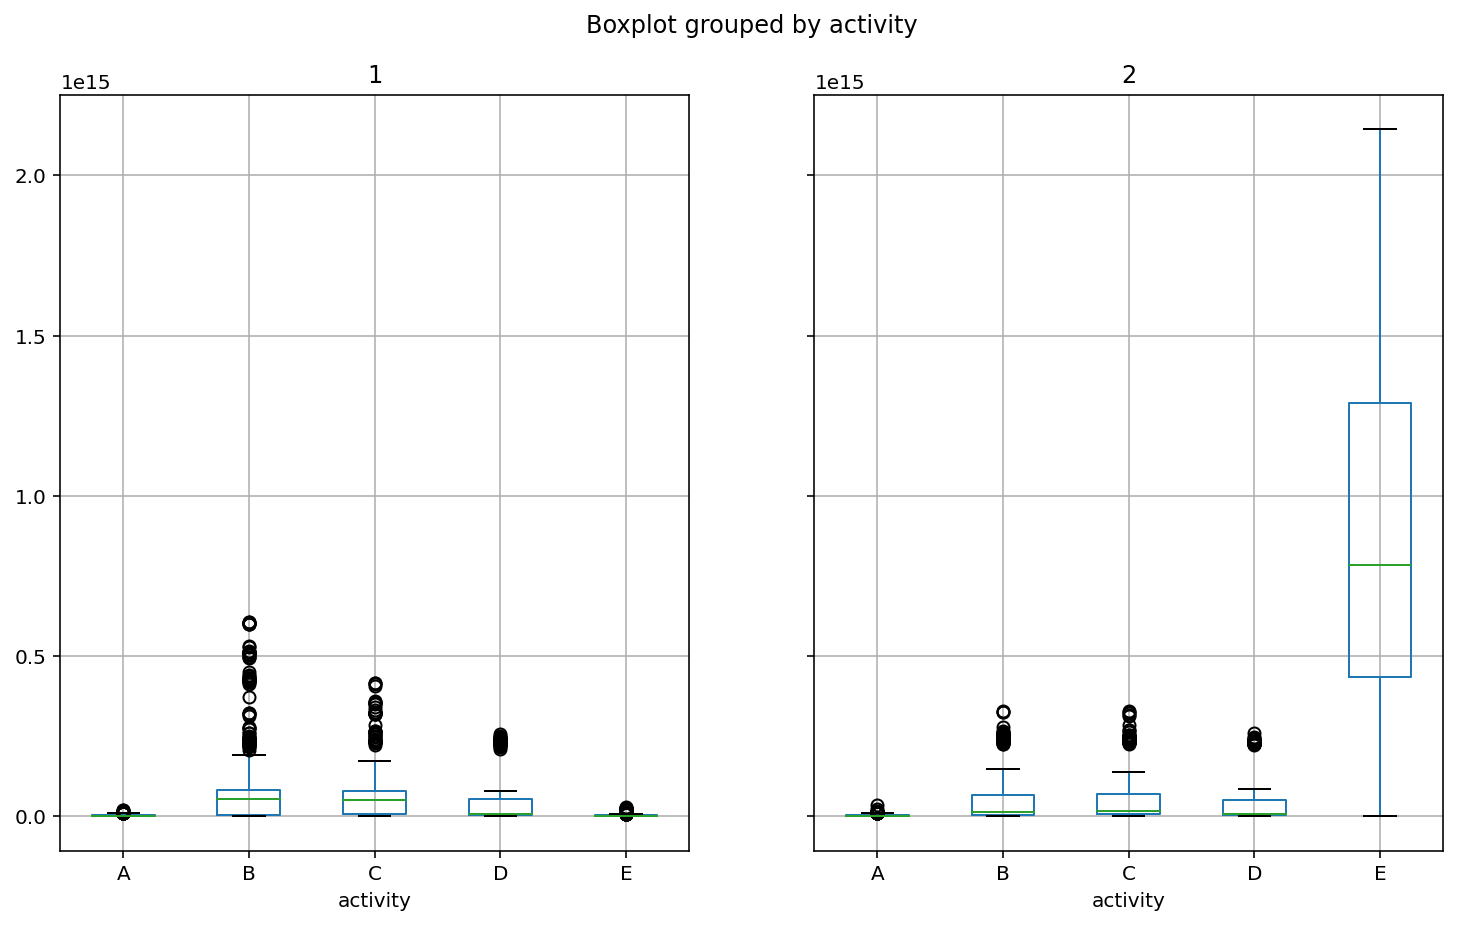

#########


(SimulationGraph(arrival=<sim.sim_graph.ArrivalNode object at 0x000001F71B65F610>, terminal=<sim.sim_graph.TerminalNode object at 0x000001F71B397550>, activity_map={'B': <sim.sim_graph.ActivityNode object at 0x000001F71B1D5F70>, 'A': <sim.sim_graph.ActivityNode object at 0x000001F71B1D5FA0>, 'E': <sim.sim_graph.ActivityNode object at 0x000001F71B1ED7C0>, 'D': <sim.sim_graph.ActivityNode object at 0x000001F71B1EDB20>, 'C': <sim.sim_graph.ActivityNode object at 0x000001F71B1ED610>}, decision_map={'p_7': <sim.sim_graph.XorSplit object at 0x000001F71B1ED700>}),
 <sim.model_parameters.ModelConfiguration at 0x1f71f23d9a0>)

In [12]:
fit_to_log((net, im, fm), flog)